In [173]:
import numpy as np
import h5py
import yaml
import os
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('dark_background')


In [68]:
run_duration = 360
outro_duration, intro_duration = 16, 16
trial_duration = 4
total_n_trials = int(run_duration / trial_duration)
n_empty_trials = 10
print(total_n_trials)

90


### Train trials, 
uniformly distributed across the circle

In [72]:
def create_train_order(total_n_trials=90, 
                        n_empty_trials=10, 
                        n_ori_distribution_blocks=4,
                        empty_trial_slack=2,
                        orientation_offset=0):
    """
    Returns a list of trial orientations, one for each trial.
    """
    basic_orientations = np.linspace(0, np.pi, total_n_trials-n_empty_trials, endpoint=False) + orientation_offset

    empty_stride_f = total_n_trials/(n_empty_trials+1)
    empty_trials = np.cumsum(np.ones(n_empty_trials)*empty_stride_f).astype(int)
    empty_trials += np.random.randint(-2,2,size=len(empty_trials))

    random_orientations = np.array([np.random.permutation(a) 
                                    for a in [basic_orientations[i::n_ori_distribution_blocks] 
                                                        for i in range(n_ori_distribution_blocks)]]).ravel()
    
    orientations = np.zeros(total_n_trials)
    skip = 0
    for i in range(total_n_trials):
        if i in empty_trials:
            orientations[i] = np.nan
            skip += 1
        else:
            orientations[i] = random_orientations[i-skip]

    return orientations

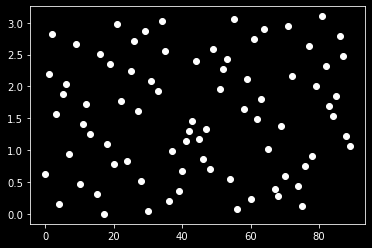

In [73]:
plt.plot(create_train_order(), 'wo')

## Test trials

these implement blocks with different spreads and mean orientations

(0.0, 3.141592653589793)

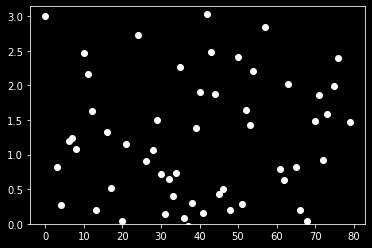

In [54]:
plt.plot(np.random.vonmises(np.pi/4, 0.5, total_n_trials-n_empty_trials), 'wo')
plt.ylim([0,np.pi])

In [177]:
# blocks defined in the range -np.pi, np.pi for von mises generation of trial values. 
# scale back to 0, np.pi for orientation afterwards. 

red_n_blocks, green_n_blocks = np.random.randint(2,7,2)

red_means = np.random.permutation(np.fmod(np.random.rand() + np.linspace(0, 1, red_n_blocks, endpoint=False), 1) * np.pi * 2 -np.pi)
green_means = np.random.permutation(np.fmod(np.random.rand() + np.linspace(0, 1, green_n_blocks, endpoint=False), 1) * np.pi * 2 -np.pi)

# these values are calculated later on, but it's handy to hardcode them here.
# values below are for an overlap of 2.2 (for an x array of 1000 values, see below)
blocks_optimal_kappas = [[2,3,4,5,6,7,8,9,10], 
                        [0.53484535,  0.75227456,  1.71685942,  3.65647883,  6.15586787, 9.36421705, 13.29301894, 17.93716296, 23.43526506]]

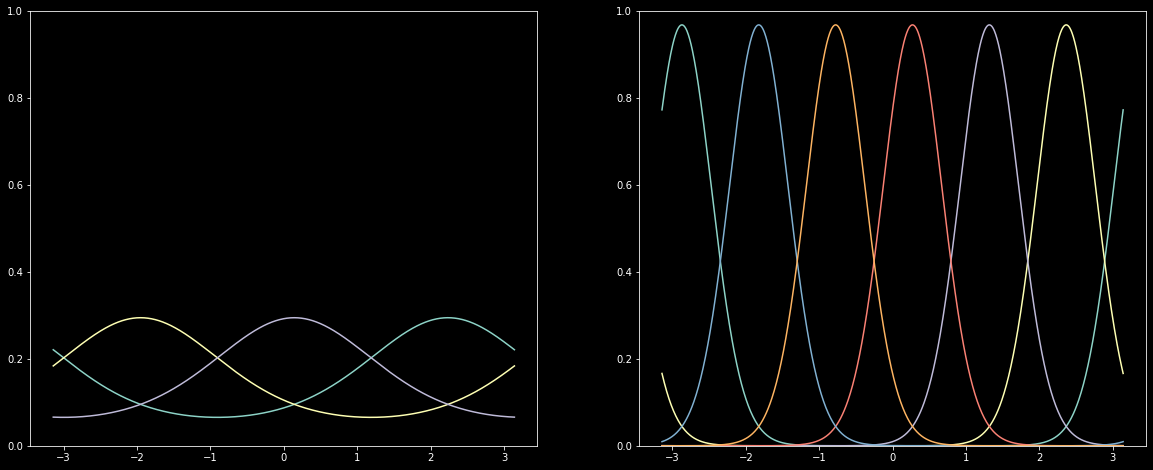

In [178]:
f, axs = plt.subplots(1,2,figsize=(20,8))
axs[0].set_ylim([0,1])
axs[1].set_ylim([0,1])
for rm in red_means:
    axs[0].plot(np.linspace(-np.pi, np.pi, 1000), 
                stats.vonmises.pdf(np.linspace(-np.pi, np.pi, 1000), kappa=blocks_optimal_kappas[1][blocks_optimal_kappas[0].index(len(red_means))], loc=rm))
for gm in green_means:
    axs[1].plot(np.linspace(-np.pi, np.pi, 1000), 
                stats.vonmises.pdf(np.linspace(-np.pi, np.pi, 1000), kappa=blocks_optimal_kappas[1][blocks_optimal_kappas[0].index(len(green_means))], loc=gm))                

### Calculate kappa values for each of the possible number of blocks in a run

In [174]:
def overlap_vm(n_blocks, kappa_function):
    x = np.linspace(-np.pi, np.pi, 100)
    locs = [0, 2*np.pi/n_blocks]
    return np.array([np.dot(stats.vonmises.pdf(x, kappa=k, loc=locs[0]), stats.vonmises.pdf(x, kappa=k, loc=locs[1])) 
        for k in kappa_function])

,kappa
n blocks,
2,0.534845
3,0.752275
4,1.716859
5,3.656479
6,6.155868
7,9.364217
8,13.293019
9,17.937163
10,23.435265


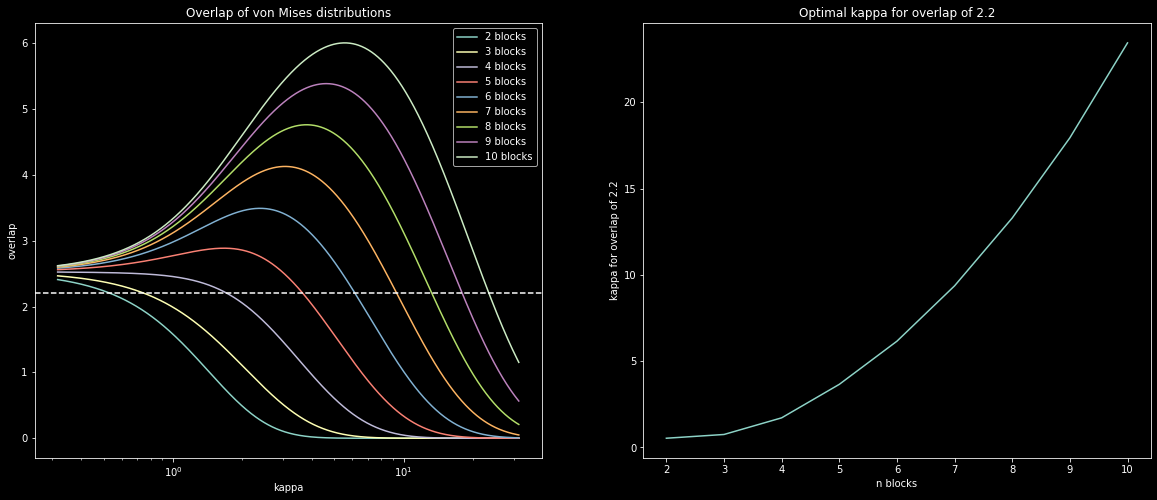

In [179]:
desired_vm_overlap = 2.2
f, axs = plt.subplots(1,2,figsize=(20,8))
x = np.logspace(-0.5, 1.5, 1000)
for n in [2,3,4,5,6,7,8,9,10]:
    axs[0].semilogx(x, overlap_vm(n_blocks=n, kappa_function=x), label=f'{n} blocks')
axs[0].axhline(desired_vm_overlap, color='w', linestyle='--')
axs[0].legend()
axs[0].set_xlabel('kappa')
axs[0].set_ylabel('overlap')
axs[0].set_title('Overlap of von Mises distributions')
best_kappas = np.array([x[np.argmin(np.abs(overlap_vm(n_blocks=n, kappa_function=x)-desired_vm_overlap))] 
                    for n in [2,3,4,5,6,7,8,9,10]])
axs[1].plot([2,3,4,5,6,7,8,9,10], best_kappas)
axs[1].set_xlabel('n blocks')
axs[1].set_ylabel(f'kappa for overlap of {desired_vm_overlap}')
axs[1].set_title(f'Optimal kappa for overlap of {desired_vm_overlap}')

best_kappa_df = pd.DataFrame(best_kappas, columns=['kappa'], index=pd.Series([2,3,4,5,6,7,8,9,10], name='n blocks'))
best_kappa_df

## Code up the blocks and orientations

In [262]:
def test_run_orientations(total_n_trials=90, 
                        n_empty_trials=10, 
                        empty_trial_slack=2):
    """
    Returns a list of trial orientations, one for each trial.
    """
    empty_stride_f = total_n_trials/(n_empty_trials+1)
    empty_trials = np.cumsum(np.ones(n_empty_trials)*empty_stride_f).astype(int)
    empty_trials += np.random.randint(-empty_trial_slack,empty_trial_slack+1,size=len(empty_trials))

    n_trials_each_color = (total_n_trials - n_empty_trials)//2
    red_n_blocks, green_n_blocks = np.random.randint(3,6,2)
    color_trial_dict = {}
    for i, color in enumerate(['red', 'green']):
        n_blocks = [red_n_blocks, green_n_blocks][i]
        n_trials_per_block = n_trials_each_color / n_blocks
        color_trials = np.cumsum(np.ones(n_blocks)*n_trials_per_block).astype(int)
        color_trials += np.random.randint(-2,3,size=len(color_trials))
        color_trials = np.r_[0,color_trials]
        color_trials[-1] = n_trials_each_color
        color_trial_indices = [np.arange(color_trials[j], color_trials[j+1]) for j in range(len(color_trials)-1)]
        block_means = np.random.permutation(np.fmod(np.random.rand() + np.linspace(0, 1, n_blocks, endpoint=False), 1) * np.pi * 2 -np.pi)
        block_kappas = np.ones(n_blocks) * blocks_optimal_kappas[1][blocks_optimal_kappas[0].index(n_blocks)]
        orientations = [np.random.vonmises(mu=bm, kappa=bk, size=len(ind)) for bm, bk, ind in zip(block_means, block_kappas, color_trial_indices)]
        df_data = np.zeros((n_trials_each_color, 4))
        for b in range(n_blocks):
            df_data[color_trial_indices[b], 0] = b+1
            df_data[color_trial_indices[b], 1] = block_means[b]
            df_data[color_trial_indices[b], 2] = block_kappas[b]
        df_data[:,-1] = np.concatenate(orientations)
        data_df = pd.DataFrame(df_data, columns=['block', 'block_mean', 'block_kappa', 'orientation'])
        data_df['color'] = color
        color_trial_dict[color] = {'data_df': data_df, 'trials': color_trials, 'means':block_means, 'kappas':block_kappas, 'indices': color_trial_indices, 'orientations': orientations}
        
    which_color_which_trial = np.random.permutation(np.r_[np.zeros(n_trials_each_color), np.ones(n_trials_each_color)]).astype(bool)
    all_color_df = pd.DataFrame(np.zeros((which_color_which_trial.shape[0], 5)), 
                        columns=['block', 'block_mean', 'block_kappa', 'orientation', 'color'])
    all_color_df.iloc[which_color_which_trial] = color_trial_dict['red']['data_df']
    all_color_df.iloc[~which_color_which_trial] = color_trial_dict['green']['data_df']

    for et in empty_trials:
        all_color_df.loc[et-0.5] = [0, np.nan, np.nan, np.nan, 'empty']
    all_color_df = all_color_df.sort_index().reset_index(drop=True)

    return all_color_df


(array([ 8., 10.,  3.,  7.,  1.,  7.,  4.]),
 array([-3.14159265, -2.24399475, -1.34639685, -0.44879895,  0.44879895,
         1.34639685,  2.24399475,  3.14159265]),
 <BarContainer object of 7 artists>)

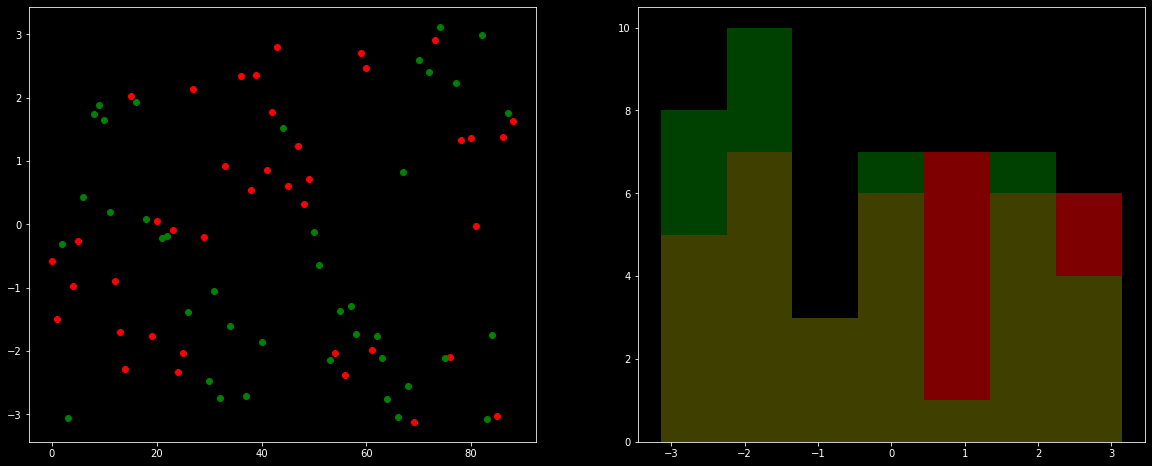

In [277]:
df = test_run_orientations()

f, axs = plt.subplots(1,2,figsize=(20,8))

axs[0].plot(df.index[df['color']=='red'], df['orientation'][df['color']=='red'], 'ro')
axs[0].plot(df.index[df['color']=='green'], df['orientation'][df['color']=='green'], 'go')

axs[1].hist(df['orientation'][df['color']=='red'], bins=np.linspace(-np.pi, np.pi, 8), color='r', alpha=0.5)
axs[1].hist(df['orientation'][df['color']=='green'], bins=np.linspace(-np.pi, np.pi, 8), color='g', alpha=0.5)
